# Plots of null geodesics in Kerr spacetime
## Computation with `kerrgeodesic_gw`

This Jupyter/SageMath notebook is relative to the lectures
[Geometry and physics of black holes](https://luth.obspm.fr/~luthier/gourgoulhon/bh16/).

It requires [SageMath](http://www.sagemath.org/) (version $\geq$ 8.2), with the package [kerrgeodesic_gw](https://github.com/BlackHolePerturbationToolkit/kerrgeodesic_gw) (version $\geq$ 0.3.2). To install the latter, simply run 
```
sage -pip install kerrgeodesic_gw
```
in a terminal.

In [1]:
version()

'SageMath version 9.2, Release Date: 2020-10-24'

First, we set up the notebook to use LaTeX-formatted display:

In [2]:
%display latex

and we ask for CPU demanding computations to be performed in parallel on 8 processes:

In [3]:
Parallelism().set(nproc=8)

A Kerr black bole is entirely defined by two parameters $(m, a)$, where $m$ is the black hole mass and $a$ is the black hole angular momentum divided by $m$.
In this notebook, we shall set $m=1$ and we denote the angular momentum parameter $a$ by the symbolic variable `a`, using `a0` for a specific numerical value:

In [4]:
a = var('a')
a0 = 0.95

The spacetime object is created as an instance of the class `KerrBH`:

In [5]:
from kerrgeodesic_gw import KerrBH
M = KerrBH(a)
print(M)

Kerr spacetime M


The Boyer-Lindquist coordinate $r$ of the event horizon:

In [6]:
rH = M.event_horizon_radius()
rH

sqrt(-a^2 + 1) + 1

In [7]:
rH0 = rH.subs({a: a0})
rH0

1.31224989991992

The method `boyer_lindquist_coordinates()` returns the chart of Boyer-Lindquist coordinates `BL` and allows the user to instanciate the Python variables `(t, r, th, ph)` to the coordinates $(t,r,\theta,\phi)$:

In [8]:
BL.<t, r, th, ph> = M.boyer_lindquist_coordinates()
BL

Chart (M, (t, r, th, ph))

The metric tensor is naturally returned by the method `metric()`:

In [9]:
g = M.metric()
g.display()

g = -(a^2*cos(th)^2 + r^2 - 2*r)/(a^2*cos(th)^2 + r^2) dt*dt - 2*a*r*sin(th)^2/(a^2*cos(th)^2 + r^2) dt*dph + (a^2*cos(th)^2 + r^2)/(a^2 + r^2 - 2*r) dr*dr + (a^2*cos(th)^2 + r^2) dth*dth - 2*a*r*sin(th)^2/(a^2*cos(th)^2 + r^2) dph*dt + (2*a^2*r*sin(th)^4 + (a^2*r^2 + r^4 + (a^4 + a^2*r^2)*cos(th)^2)*sin(th)^2)/(a^2*cos(th)^2 + r^2) dph*dph

## Spherical photon orbits

Functions $\ell(r_0)$ and $q(r_0)$ for spherical photon orbits:

In [10]:
r = var('r')
lsph(a, r) = (r^2*(3 - r) - a^2*(r + 1))/(a*(r -1))
lsph

(a, r) |--> -(a^2*(r + 1) + (r - 3)*r^2)/(a*(r - 1))

In [11]:
qsph(a, r) = r^3 / (a^2*(r - 1)^2) * (4*a^2 - r*(r - 3)^2)
qsph

(a, r) |--> -((r - 3)^2*r - 4*a^2)*r^3/(a^2*(r - 1)^2)

$\theta$-turning points:

In [12]:
theta0(a, l, q) = arccos(sqrt(1/2*(1 - (l^2+q)/a^2 + sqrt((1 - (l^2+q)/a^2)^2 + 4*q/a^2))))
theta0

(a, l, q) |--> arccos(sqrt(1/2*sqrt(((l^2 + q)/a^2 - 1)^2 + 4*q/a^2) - 1/2*(l^2 + q)/a^2 + 1/2))

In [13]:
theta1(a, l, q) = arccos(sqrt(1/2*(1 - (l^2+q)/a^2 - sqrt((1 - (l^2+q)/a^2)^2 + 4*q/a^2))))
theta1

(a, l, q) |--> arccos(sqrt(-1/2*sqrt(((l^2 + q)/a^2 - 1)^2 + 4*q/a^2) - 1/2*(l^2 + q)/a^2 + 1/2))

### Spherical photon orbit at $r_0 = 3 m$ ($q = q_{\rm max} = 27 m^2$)

In [14]:
r0 = 3.
E = 1
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(-1.90000000000000, 27.0000000000000)

In [15]:
P = M.point((0, r0, pi/2, 0), name='P')
print(P)

Point P on the Kerr spacetime M


A geodesic is constructed by providing the range $[\lambda_{\rm min},\lambda_{\rm max}]$ of the affine parameter $\lambda$, the initial point and either 
 - (i) the Boyer-Lindquist components $(p^t_0, p^r_0, p^\theta_0, p^\phi_0)$ of the initial 4-momentum vector
   $p_0 = \left. \frac{\mathrm{d}x}{\mathrm{d}\lambda}\right| _{\lambda_{\rm min}}$,
 - (ii) the four integral of motions $(\mu, E, L, Q)$
 - or (iii) some of the components of $p_0$ along with with some integrals of motion. 

In [16]:
lmax = 100 # lambda_max

In [17]:
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.00000000000000 d/dt + (9.36596633575423e-9) d/dr + 0.577350269189626 d/dth

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [18]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.00000000000000 d/dt + 0.577350269189626 d/dth

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


The numerical integration of the geodesic equation is performed via `integrate()`, by providing the integration step $\delta\lambda$:

In [19]:
Li.integrate(step=0.001, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,-
,,,,
,,,,
,,,,


In [20]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (291.1717434701057, 3.0, 2.144493861874287, -39.55667803565552)

In [21]:
Li.plot(prange=(0, 0.32*lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.15, width_tangent=2, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

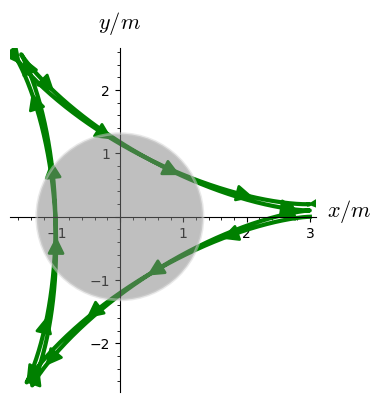

In [22]:
graph = Li.plot(coordinates='xy', prange=(0, 0.32*lmax), plot_points=2000, 
                thickness=3, color='green', display_tangent=True, scale=0.15, 
                width_tangent=2, color_tangent='green', plot_points_tangent=20, 
                horizon_color='lightgrey', axes_labels=[r'$x/m$', r'$y/m$'])
graph.save("gik_spher_3d_r_30_xy.pdf")
graph

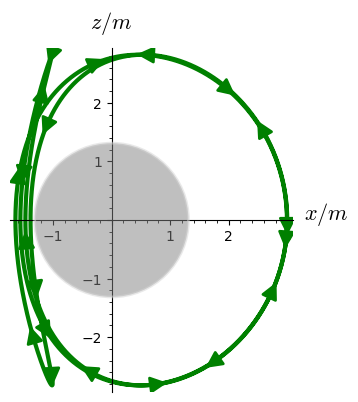

In [23]:
Li.plot(coordinates='xz', prange=(0, 0.32*lmax), plot_points=2000, 
        thickness=3, color='green', display_tangent=True, scale=0.15, 
        width_tangent=2, color_tangent='green', plot_points_tangent=20, 
        horizon_color='lightgrey', axes_labels=[r'$x/m$', r'$z/m$'])

### Prograde spherical photon orbit at $r_0 = 1.6m$

In [24]:
r0 = 1.6
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(2.17105263157895, 5.97569713758080)

In [25]:
P = M.point((0, r0, pi/2, 0), name='P')
lmax = 70
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 7.66666666666666 d/dt + (1.74608999691187e-24 + 2.85158136717879e-8*I) d/dr + 0.954892151626195 d/dth + 2.45614035087719 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [26]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 7.66666666666666 d/dt + 0.954892151626195 d/dth + 2.45614035087719 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [27]:
Li.integrate(step=0.0004, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [28]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (492.9599102672748, 1.599974600261711, 0.8276182451833887, 185.0198306183178)

In [29]:
Li.plot(prange=(0, 0.11*lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.03, width_tangent=1, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

In [30]:
Li.plot(prange=(0, lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.03, width_tangent=1, color_tangent='green', 
        plot_points_tangent=40, horizon_color='lightgrey')

Graphics3d Object

### Spherical photon orbit at $r_0=2.8m$

In [31]:
r0 = 2.8
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(-1.08859649122807, 26.2604206422489)

In [32]:
P = M.point((0, r0, pi/2, 0), name='P')
lmax = 100
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.22222222222222 d/dt + (4.65527024480212e-25 + 7.60263326216718e-9*I) d/dr + 0.653634213345212 d/dth + 0.116959064327486 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [33]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.22222222222222 d/dt + 0.653634213345212 d/dth + 0.116959064327486 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [34]:
Li.integrate(step=0.001, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [35]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (310.4228769082733, 2.8, 2.462502125969338, -39.07005458983995)

In [36]:
Li.plot(prange=(0, 0.38*lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.12, width_tangent=2, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

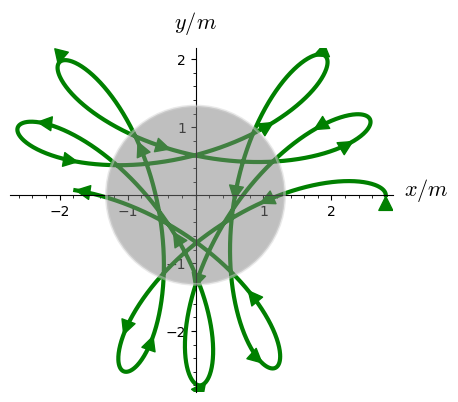

In [37]:
graph = Li.plot(coordinates='xy', prange=(0, 0.38*lmax), plot_points=2000, 
                thickness=3, color='green', display_tangent=True, scale=0.01, 
                width_tangent=1, color_tangent='green', 
                plot_points_tangent=20, horizon_color='lightgrey',
                axes_labels=[r'$x/m$', r'$y/m$'])
graph.save("gik_spher_3d_r_28_xy.pdf")
graph

In [38]:
Li.plot(coordinates='txy', prange=(0, 0.4*lmax), plot_points=2000, 
        thickness=3, color='green', display_tangent=True, scale=0.2, 
        width_tangent=2, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

### Retrograde spherical photon orbit at $r_0 = 3.9 m$

In [39]:
r0 = 3.9
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(-6.57395644283122, 3.52474056409564)

In [40]:
P = M.point((0, r0, pi/2, 0), name='P')

In [41]:
lmax = 100
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 2.37931034482759 d/dt + (2.22112222707613e-8) d/dr + 0.123433875307859 d/dth - 0.326678765880218 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [42]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 2.37931034482759 d/dt + 0.123433875307859 d/dth - 0.326678765880218 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [43]:
Li.integrate(step=0.001, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [44]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (237.38270015383975, 3.9, 1.6881755637536546, -34.301693666892874)

In [45]:
Li.plot(prange=(0, 0.55*lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.15, width_tangent=2, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

### A polar spherical photon orbit

In [46]:
rph_pol(a) = 1 + 2*sqrt(1 - a^2/3)*cos(1/3*arccos((1 - a^2)/(1 - a^2/3)^(3/2)))
rph_pol

a |--> 2*sqrt(-1/3*a^2 + 1)*cos(1/3*arccos(-(a^2 - 1)/(-1/3*a^2 + 1)^(3/2))) + 1

In [47]:
r0 = rph_pol(a0)
L = lsph(a0, r0)
Q = qsph(a0, r0)
r0, L, Q

(2.49269429554008, -6.26333640524599e-16, 22.8640201857508)

In [48]:
lmax = 30
P = M.point((0, r0, pi/2, 0), name='P')
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=0, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.67971815257238 d/dt + (1.31343299672075e-24 + 2.14499886438313e-8*I) d/dr + 0.769552507817167 d/dth + 0.357746396090726 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [49]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 3.67971815257238 d/dt + 0.769552507817167 d/dth + 0.357746396090726 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [50]:
Li.integrate(step=0.002, method='dopri5')
#Li.check_integrals_of_motion(0.99*lmax)

/home/eric/sage/9.2/local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dopri5: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [51]:
Li.plot(prange=(0, 0.5*lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.2, width_tangent=2, color_tangent='green', 
        plot_points_tangent=20, horizon_color='lightgrey')

Graphics3d Object

## Inner spherical orbits

To plot the inner orbits, and in particular orbits with $r<0$, we use a map from Kerr spacetime to the Euclidean space based on the radial coordinate
$$
    \hat{r} := \frac{1}{2} \left( r + \sqrt{r^2 + 4m^2} \right) 
$$
instead of the Boyer-Lindquist $r$. 

In [52]:
E4 = M.map_to_Euclidean().codomain()
X4 = E4.cartesian_coordinates()
t, x, y, z = X4[:]
X4

Chart (E^4, (t, x, y, z))

In [53]:
rhat = 1/2*(r + sqrt(r^2 + 4))
rhat

1/2*r + 1/2*sqrt(r^2 + 4)

In [54]:
F = M.diff_map(E4, {(BL, X4): [t, rhat*sin(th)*cos(ph),
                               rhat*sin(th)*sin(ph),
                               rhat*cos(th)]}, name='F')
F.display()

F: M --> E^4
   (t, r, th, ph) |--> (t, x, y, z) = (t, 1/2*(r + sqrt(r^2 + 4))*cos(ph)*sin(th), 1/2*(r + sqrt(r^2 + 4))*sin(ph)*sin(th), 1/2*(r + sqrt(r^2 + 4))*cos(th))

### Marginally stable spherical photon orbit

In [55]:
r0 = 1 - (1 - a0^2)^(1/3)
r0

0.539741795874205

In [56]:
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(1.53893384905757, 0.282109845505914)

In [57]:
lmax = 50
P = M.point((0, r0, pi/2, 0), name='P')
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = -7.69077392677338 d/dt + (3.13205131833926e-24 + 5.11502797462896e-8*I) d/dr + 1.82321137638829 d/dth - 5.62672311935440 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [58]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = -7.69077392677338 d/dt + 1.82321137638829 d/dth - 5.62672311935440 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [59]:
Li.integrate(step=0.001, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [60]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (-302.91453819062644,
 0.5397417961010423,
 1.5090634888129522,
 -210.47540919172215)

Plot with respect to $\hat{r}$ coordinate:

In [61]:
sing_ring = circle((0,0,0), 1, thickness=3, color='orangered')
r_minf = sphere((0,0,0), 0.02, color='black') \
         + text3d("r=\u2212\u221E", (0,0,0.05), fontfamily='serif', 
                  fontstyle='italic', fontsize=20)

In [62]:
graph = Li.plot_integrated(chart=X4, mapping=F,
                   ambient_coords=(x,y,z), prange=(0, 0.06*lmax),
                   thickness=3, plot_points=2000, color='green',
                   display_tangent=True, scale=0.015, width_tangent=1, 
                   color_tangent='green', plot_points_tangent=20,
                   label_axes=False)
graph += sing_ring + r_minf
graph

Graphics3d Object

### Stable inner spherical photon orbit at $r_0 = 0.5 m$

In [63]:
r0 = 0.5
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(1.53421052631579, 0.268698060941828)

In [64]:
lmax = 30
P = M.point((0, r0, pi/2, 0), name='P')
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = -7.00000000000000 d/dt + 2.07344374774655 d/dth - 5.26315789473685 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [65]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = -7.00000000000000 d/dt + 2.07344374774655 d/dth - 5.26315789473685 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [66]:
Li.integrate(step=0.0004, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [67]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (-160.2656841305653,
 0.5000000000003154,
 1.4610686498436227,
 -113.33060855014394)

Plot in (Cartesian) Boyer-Lindquist coordinates:

In [68]:
Li.plot(prange=(0, lmax), plot_points=2000, thickness=3, color='green',
        display_tangent=True, scale=0.01, width_tangent=1, color_tangent='green', 
        plot_points_tangent=20, plot_horizon=False)

Graphics3d Object

Plot with respect to $\hat{r}$ coordinate:

In [69]:
graph1 = Li.plot_integrated(chart=X4, mapping=F,
                   ambient_coords=(x,y,z), prange=(0, 0.25*lmax),
                   thickness=3, plot_points=2000, color='green',
                   display_tangent=True, scale=0.015, width_tangent=1, 
                   color_tangent='green', plot_points_tangent=20,
                   label_axes=False)
graph1 += sing_ring + r_minf
graph1

Graphics3d Object

### Inner spherical photon orbit at $r_0 = -0.46 m$

In [70]:
r0 = -0.46
L = lsph(a0, r0)
Q = qsph(a0, r0)
L, Q

(-0.176485940879596, -0.461285155596124)

In [71]:
th0 = theta0(a0, L, Q)
th1 = theta1(a0, L, Q)
th0, th1

(0.281889824619659, 0.731306339672501)

In [72]:
lmax = 20
P = M.point((0, r0, (th0+th1)/2, 0), name='P')
Li = M.geodesic([0, lmax], P, mu=0, E=E, L=L, Q=Q, a_num=a0,
                name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 0.357024161116205 d/dt + (1.84776601065215e-8) d/dr + 0.396167049160545 d/dth - 1.22114489356954 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [73]:
v0 = Li.initial_tangent_vector()
Li = M.geodesic([0, lmax], P, pt0=v0[0], pr0=0, pth0=v0[2], pph0=v0[3],
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 0.357024161116205 d/dt + 0.396167049160545 d/dth - 1.22114489356954 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [74]:
Li.integrate(step=0.0004, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [75]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (6.610047313116614, -0.46, 0.3935945545623688, -28.8953848944196)

In [76]:
graph = Li.plot_integrated(chart=X4, mapping=F,
                   ambient_coords=(x,y,z), prange=(0, lmax),
                   thickness=3, plot_points=2000, color='green',
                   display_tangent=True, scale=0.1, width_tangent=1, 
                   color_tangent='green', plot_points_tangent=20,
                   label_axes=False)

In [77]:
graph += sing_ring + r_minf
graph

Graphics3d Object

In [78]:
graph + graph1

Graphics3d Object